# Comparing pykan vs efficient-kan

This notebook compares the original pykan implementation with efficient-kan on a simple sinusoidal function fitting task to verify their equivalence.

In [46]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time

# Import both implementations
from kan import KAN as PyKAN
from efficient_kan import KAN as EfficientKAN
from kan.MLP import MLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

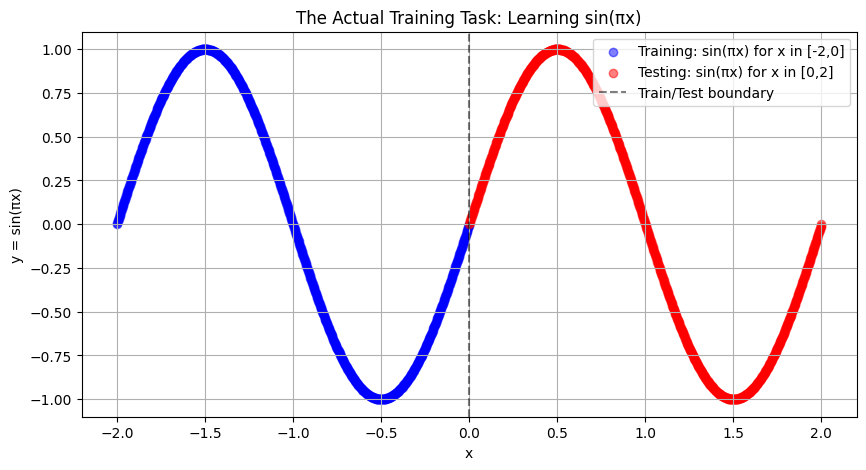

In [47]:
def generate_1d_data(n_train=800, n_test=800):
    x_train = torch.linspace(-2, 0, n_train).reshape(-1, 1)
    y_train = torch.sin(torch.pi * x_train)
    x_test = torch.linspace(0, 2, n_test).reshape(-1, 1) 
    y_test = torch.sin(torch.pi * x_test)
    return {
        'train_input': x_train,
        'train_label': y_train,
        'test_input': x_test,
        'test_label': y_test
    }

# Generate dataset
dataset = generate_1d_data()
plt.figure(figsize=(10, 5))

# Plot the actual training relationship
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='blue', alpha=0.5, label='Training: sin(πx) for x in [-2,0]')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='red', alpha=0.5, label='Testing: sin(πx) for x in [0,2]')

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Train/Test boundary')
plt.title('The Actual Training Task: Learning sin(πx)')
plt.xlabel('x')
plt.ylabel('y = sin(πx)')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# Define grid sizes and steps
grid_sizes = [3, 5, 10, 20, 50, 200] # 500, 1000] # took longer than 30 minutes to train even once
n_steps = 2000

def train_pykan(dataset, grid_size):
    model = PyKAN(width=[1,3,1], grid=grid_size, k=3, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=n_steps, 
                       lamb=0.001, 
                       lamb_entropy=2.0)
    return model, results['train_loss'][-1], results['test_loss'][-1]

def train_efficient_kan(dataset, grid_size):
    model = EfficientKAN([1,3,1], grid_size=grid_size, spline_order=3)
    model = model.to(device)
    
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    
    train_losses = []
    test_losses = []
    
    for i in tqdm(range(n_steps)):
        def closure():
            optimizer.zero_grad()
            y_pred = model(dataset['train_input'])
            loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        # Record losses every 50 steps to save memory
        if i % 50 == 0:
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    model(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    model(dataset['test_input']), 
                    dataset['test_label']
                )
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
                
    return model, train_losses[-1], test_losses[-1]

In [49]:
# Initialize tracking arrays
pykan_train_losses = []
pykan_test_losses = []
effkan_train_losses = []
effkan_test_losses = []
mlp_train_losses = []
mlp_test_losses = []
pykan_times = []
effkan_times = []
mlp_times = []

# Store models for later use
pykan_models = []
effkan_models = []
mlp_models = []

# Training loop
for grid in grid_sizes:
    print(f"\nTraining with grid size {grid}")
    
    # Train PyKAN
    print("Training PyKAN...")
    start_time = time.time()
    pykan_model, train_loss, test_loss = train_pykan(dataset, grid)
    pykan_time = time.time() - start_time
    
    pykan_models.append(pykan_model)
    pykan_train_losses.append(train_loss)
    pykan_test_losses.append(test_loss)
    pykan_times.append(pykan_time)
    
    # Train EfficientKAN
    print("Training EfficientKAN...")
    start_time = time.time()
    effkan_model, train_loss, test_loss = train_efficient_kan(dataset, grid)
    effkan_time = time.time() - start_time
    
    effkan_models.append(effkan_model)
    effkan_train_losses.append(train_loss)
    effkan_test_losses.append(test_loss)
    effkan_times.append(effkan_time)
    
    # Train MLP with matching parameter count
    n_params = grid * (1*3 + 3*1)  # Parameters in KAN
    mlp_width = int(np.sqrt(n_params))  # Approximate width to match
    print(f"Training MLP (width={mlp_width})...")
    
    mlp = MLP(width=[1, mlp_width, 1], device=device)
    start_time = time.time()
    
    optimizer = torch.optim.LBFGS(mlp.parameters(), lr=1)
    mlp_losses = []
    
    for i in tqdm(range(n_steps)):
        def closure():
            optimizer.zero_grad()
            y_pred = mlp(dataset['train_input'])
            loss = nn.functional.mse_loss(y_pred, dataset['train_label'])
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        if i % 50 == 0:
            with torch.no_grad():
                train_loss = nn.functional.mse_loss(
                    mlp(dataset['train_input']), 
                    dataset['train_label']
                )
                test_loss = nn.functional.mse_loss(
                    mlp(dataset['test_input']), 
                    dataset['test_label']
                )
                mlp_losses.append((train_loss.item(), test_loss.item()))
    
    mlp_time = time.time() - start_time
    mlp_models.append(mlp)
    mlp_train_losses.append(mlp_losses[-1][0])
    mlp_test_losses.append(mlp_losses[-1][1])
    mlp_times.append(mlp_time)


Training with grid size 3
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.42e-03 | test_loss: 7.96e-01 | reg: 5.95e+00 | : 100%|█| 2000/2000 [00:50<00:00, 39.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [00:03<00:00, 519.25it/s]


Training MLP (width=4)...


100%|██████████| 2000/2000 [00:01<00:00, 1025.43it/s]



Training with grid size 5
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.26e-03 | test_loss: 6.75e-01 | reg: 8.08e+00 | : 100%|█| 2000/2000 [00:39<00:00, 50.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [00:05<00:00, 381.60it/s]


Training MLP (width=5)...


100%|██████████| 2000/2000 [00:02<00:00, 916.80it/s] 



Training with grid size 10
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.51e-03 | test_loss: 6.85e-01 | reg: 5.26e+00 | : 100%|█| 2000/2000 [00:49<00:00, 40.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [00:05<00:00, 358.64it/s]


Training MLP (width=7)...


100%|██████████| 2000/2000 [00:02<00:00, 799.70it/s] 



Training with grid size 20
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.71e-03 | test_loss: 7.70e-01 | reg: 5.24e+00 | : 100%|█| 2000/2000 [01:25<00:00, 23.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [00:07<00:00, 277.49it/s]


Training MLP (width=10)...


100%|██████████| 2000/2000 [00:02<00:00, 981.75it/s] 



Training with grid size 50
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.35e-02 | test_loss: 6.71e-01 | reg: 5.54e+00 | : 100%|█| 2000/2000 [01:10<00:00, 28.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [00:24<00:00, 81.63it/s] 


Training MLP (width=17)...


100%|██████████| 2000/2000 [00:02<00:00, 946.07it/s] 



Training with grid size 200
Training PyKAN...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.37e-03 | test_loss: 6.84e-01 | reg: 8.14e+00 | : 100%|█| 2000/2000 [02:34<00:00, 12.


saving model version 0.1
Training EfficientKAN...


100%|██████████| 2000/2000 [01:43<00:00, 19.35it/s] 


Training MLP (width=34)...


100%|██████████| 2000/2000 [00:02<00:00, 684.60it/s]


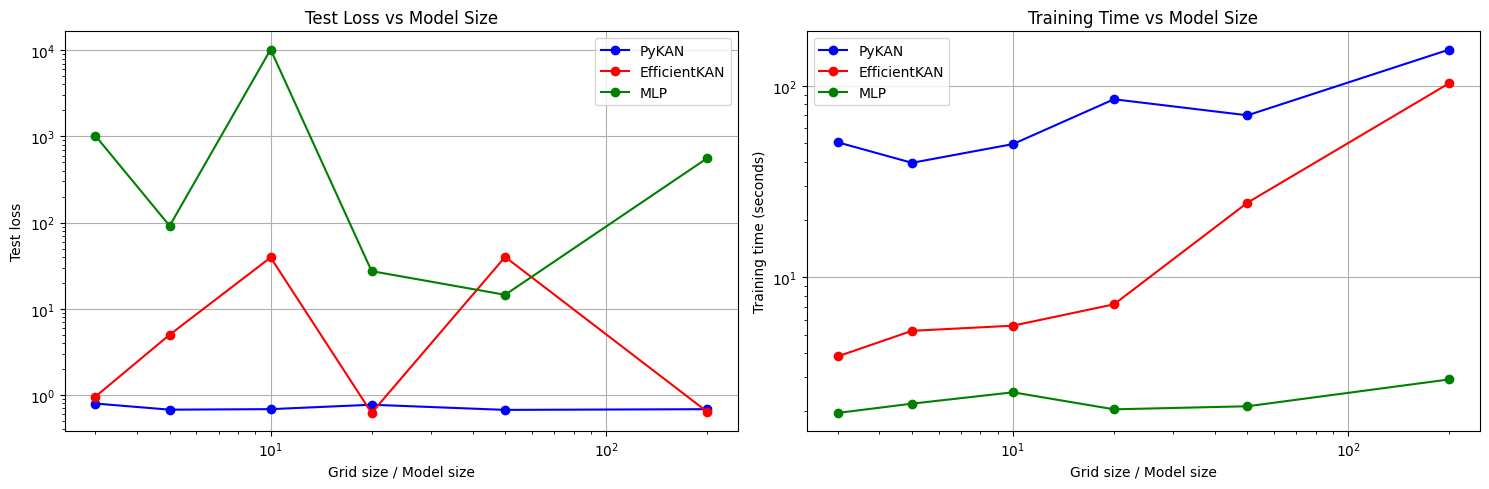

In [50]:
# Plotting
plt.figure(figsize=(15, 5))

# Test loss vs grid size plot
plt.subplot(121)
plt.loglog(grid_sizes, pykan_test_losses, 'bo-', label='PyKAN')
plt.loglog(grid_sizes, effkan_test_losses, 'ro-', label='EfficientKAN')
plt.loglog(grid_sizes, mlp_test_losses, 'go-', label='MLP')
plt.grid(True)
plt.xlabel('Grid size / Model size')
plt.ylabel('Test loss')
plt.title('Test Loss vs Model Size')
plt.legend()

# Training time plot
plt.subplot(122)
plt.loglog(grid_sizes, pykan_times, 'bo-', label='PyKAN')
plt.loglog(grid_sizes, effkan_times, 'ro-', label='EfficientKAN')
plt.loglog(grid_sizes, mlp_times, 'go-', label='MLP')
plt.grid(True)
plt.xlabel('Grid size / Model size')
plt.ylabel('Training time (seconds)')
plt.title('Training Time vs Model Size')
plt.legend()

plt.tight_layout()
plt.show()

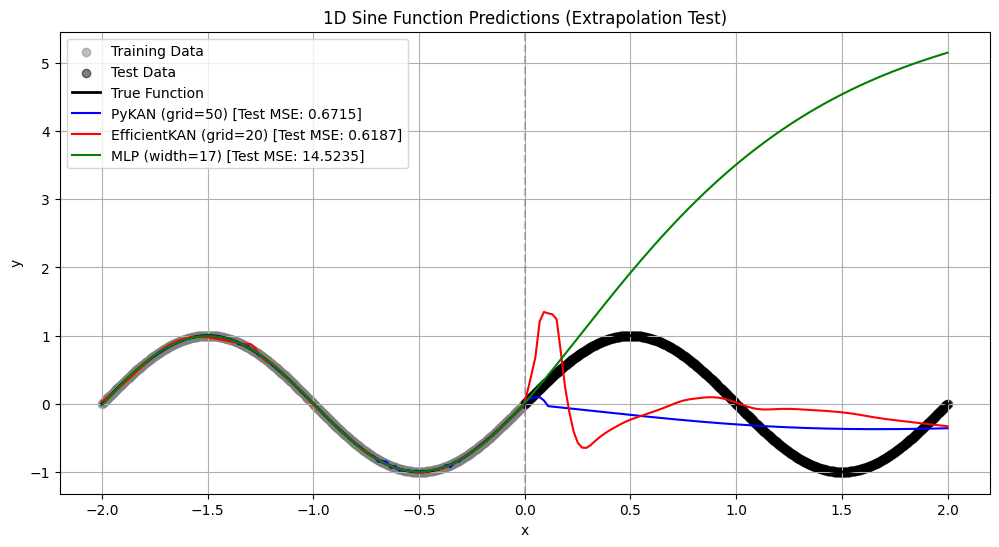

In [51]:
# Find best model for each type based on test loss
best_pykan_idx = np.argmin(pykan_test_losses)
best_effkan_idx = np.argmin(effkan_test_losses)
best_mlp_idx = np.argmin(mlp_test_losses)

# Plot predictions using best models
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
true_vals = torch.sin(np.pi * x_fine)

with torch.no_grad():
    pykan_preds = pykan_models[best_pykan_idx](x_fine)
    effkan_preds = effkan_models[best_effkan_idx](x_fine)
    mlp_preds = mlp_models[best_mlp_idx](x_fine)

plt.figure(figsize=(12, 6))
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')
plt.axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=2)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN (grid={grid_sizes[best_pykan_idx]}) [Test MSE: {pykan_test_losses[best_pykan_idx]:.4f}]')
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN (grid={grid_sizes[best_effkan_idx]}) [Test MSE: {effkan_test_losses[best_effkan_idx]:.4f}]')
plt.plot(x_fine, mlp_preds, 'g-',
        label=f'MLP (width={int(np.sqrt(grid_sizes[best_mlp_idx] * 6))}) [Test MSE: {mlp_test_losses[best_mlp_idx]:.4f}]')

plt.title('1D Sine Function Predictions (Extrapolation Test)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

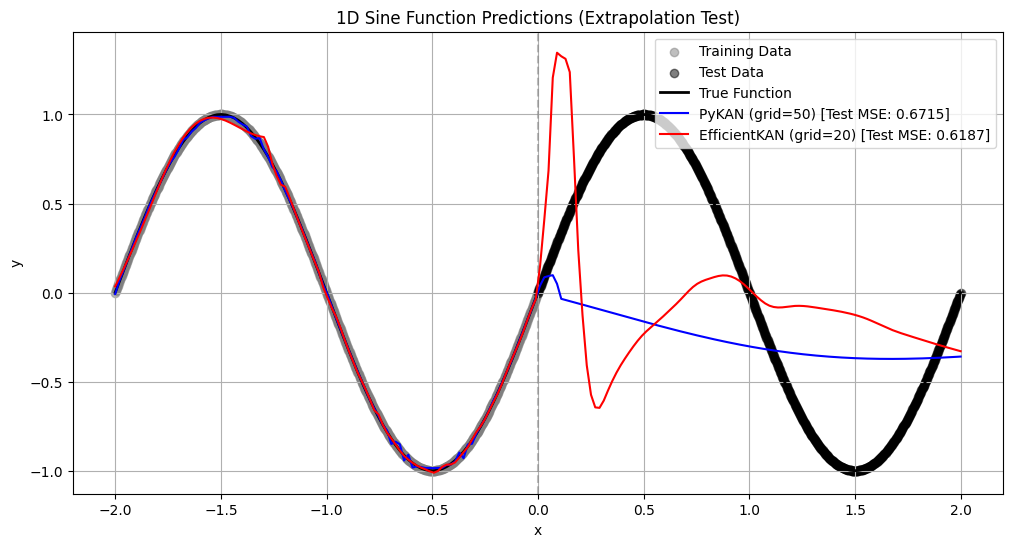

In [54]:
# Find best model for each type based on test loss
best_pykan_idx = np.argmin(pykan_test_losses)
best_effkan_idx = np.argmin(effkan_test_losses)
best_mlp_idx = np.argmin(mlp_test_losses)

# Plot predictions using best models
x_fine = torch.linspace(-2, 2, 200).reshape(-1, 1)
true_vals = torch.sin(np.pi * x_fine)

with torch.no_grad():
    pykan_preds = pykan_models[best_pykan_idx](x_fine)
    effkan_preds = effkan_models[best_effkan_idx](x_fine)
    mlp_preds = mlp_models[best_mlp_idx](x_fine)

plt.figure(figsize=(12, 6))
plt.scatter(dataset['train_input'], dataset['train_label'], 
           color='gray', alpha=0.5, label='Training Data')
plt.scatter(dataset['test_input'], dataset['test_label'], 
           color='black', alpha=0.5, label='Test Data')
plt.axvline(x=0.0, color='gray', linestyle='--', alpha=0.5)
plt.plot(x_fine, true_vals, 'k-', label='True Function', linewidth=2)
plt.plot(x_fine, pykan_preds, 'b-', 
        label=f'PyKAN (grid={grid_sizes[best_pykan_idx]}) [Test MSE: {pykan_test_losses[best_pykan_idx]:.4f}]')
plt.plot(x_fine, effkan_preds, 'r-', 
        label=f'EfficientKAN (grid={grid_sizes[best_effkan_idx]}) [Test MSE: {effkan_test_losses[best_effkan_idx]:.4f}]')

plt.title('1D Sine Function Predictions (Extrapolation Test)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

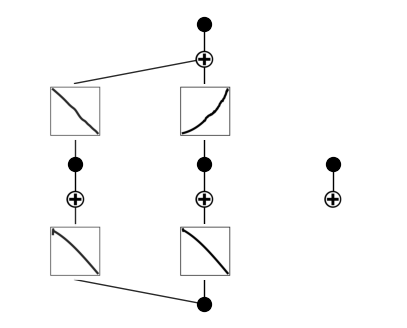

In [52]:
pykan_model.plot()

In [53]:
# First make the model symbolic
pykan_model.auto_symbolic()

# Then get and display the symbolic formula 
from kan.utils import ex_round
formula = ex_round(pykan_model.symbolic_formula()[0][0], 4)
formula

fixing (0,0,0) with cos, r2=0.99981290102005, c=2
fixing (0,0,1) with cos, r2=0.9999768733978271, c=2
fixing (0,0,2) with exp, r2=0.9996489882469177, c=2
fixing (1,0,0) with x, r2=0.9980394840240479, c=1
fixing (1,1,0) with x, r2=0.9613981246948242, c=1
fixing (1,2,0) with 1/x, r2=0.9999748468399048, c=2
saving model version 0.2


0.1732*cos(0.5574*x_1 + 3.6179) - 0.5703*cos(0.5634*x_1 + 3.615) - 0.4688